In [35]:
import numpy as np
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.nddata import Cutout2D
from astropy.wcs.utils import pixel_to_skycoord, skycoord_to_pixel
import pylab as plt
from astropy.utils.data import get_pkg_data_filename
import pandas as pd
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.patches as mpatches
import math
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon
import shapely
import warnings
from astroquery.ned import Ned
mpl.style.use('classic')


In [36]:
df = pd.read_csv('./../data/crs/total_crs.csv',index_col=0) 
hyp = pd.read_csv('./../data/info_about_galaxies/hyperleda_data.csv',index_col=0)

In [37]:
def zToMpc(z):
    return np.power(10, (z-25)/5)

def get_path_and_di42¶
def zToMpc(z):
st(gal_name,catalog):
    path = './../../data/rot_curves_corrected/' + catalog + '/' + gal_name + '_' + str.upper(catalog)
    Mpc = None    
    if (catalog=='sparc') or (catalog=='things') or (catalog=='phangs'):
            
        with open('./../../data/rot_curves_corrected/' + catalog + '/dist.dat') as dist:
            for string in dist.readlines():
                line = string.split('  ')
                if gal_name==line[0]:
                    path = path + '_kpc'
                    Mpc = float(line[1])
                    break
    
    return   path, Mpc       

def epic_freq(vel_poly, R, dR):
    return np.sqrt(2.) * vel_poly / R

def velcurve_error(gal_name,catalog,deg=None):
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad), max(rad), 100)
    
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    flag = True
    error = 0.0
    while flag:
        error+=0.01
        points=0
        for i,r in enumerate(rad):
            if (1.- error) * velocity_approx(r) <= vel[i] <= (1.+ error) * velocity_approx(r):
                points+=1
                
            if points/len(rad) >= 0.6:
                flag=False
        
    return error

### IC 0342

In [38]:
def get_Omega_and_error(gal_name,catalog,deg=None,inkpc=False, islim=False):
    path, Mpc = get_path_and_dist(gal_name,catalog)
    
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
        
    dR = (max(rad) - min(rad)) / 20
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [350,564,910]
    cr_l = [340,540,910]
    cr_r = [360,585,910]
   
         
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,catalog,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        altname = Ned.query_object(gal_name)['Object Name']

        modz = hyp[hyp['name']==altname[0]].modz.to_numpy()
        Mpc = zToMpc(modz)
        if Mpc > 0.:
            scale = math.pi / (180 * 3600) * Mpc * 10**3
            Omega = Omega / scale
            err_l = err_l / scale
            err_r = err_r / scale
            Omega = Omega.tolist()
            err_l = err_l.tolist()
            err_r = err_r.tolist()
            return  Omega, err_l, err_r
        else:
            modz = hyp[hyp['name']==altname[0]].mod0.to_numpy()
            Mpc = zToMpc(modz) 
            if Mpc > 0.:
                scale = math.pi / (180 * 3600) * Mpc * 10**3
                Omega = Omega / scale
                err_l = err_l / scale
                err_r = err_r / scale
                Omega = Omega.tolist()
                err_l = err_l.tolist()
                err_r = err_r.tolist()
                return  Omega, err_l, err_r
            else:

                print('There is no value for distance for galaxy '+gal_name+' in hyperleda')
                return np.zeros(len(Omega)),np.zeros(len(Omega)),np.zeros(len(Omega))


    else:

        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,catalog,deg=None,figsize=None,ax=None): 
    
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
    
    
    cr = [350,565,910]
    method = ['cross','cross','metallicity']
 
            
              
    lim  = max(max(rad),4*max(cr))
    points = np.linspace(min(rad), lim, 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    
    dR = (max(rad) - min(rad)) / 20
    
    err = velcurve_error(gal_name,catalog,deg=deg) 
        
    
    
    kappa = [epic_freq(velocity_approx(r), r, dR) for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx(r), r, dR) for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx(r), r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    Omega_kpc, err_l_kpc, err_r_kpc = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=True)
    Omega, err_l, err_r = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=False)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=max(rad)):
                if Omega_kpc[ind] == 0:
                   
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]],
                         label = r'$\Omega_p = $'+str("%.1f" % Omega[ind])+'+'+str("%.1f" % err_r[ind])+'-'+str("%.1f" % err_l[ind])+' км/с/" ('+ str("%.1f" %val)+'")')
                else:
                    array = zip(Omega_kpc,err_l_kpc,err_r_kpc)
                    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                    Omega_kpc = [x[0] for x in array_sort]
                    err_l_kpc = [x[1] for x in array_sort]
                    err_r_kpc = [x[2] for x in array_sort]
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.17,color=method_color[method[ind]])
                         
        
                xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                                 label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc ('+ str("%.1f" %val)+'")')
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                             label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
               
            
        plt.ylim(0,0.65)
    
        if len(Omega)>2 :
            plt.xlim(0,min(max(points),max(1.1*y_new,1.1*max(cr))))
        elif (len(Omega)<=2) & (y_new==0):
            plt.xlim(0,min(max(points),2.5*max(cr)))    
        elif (len(Omega)<=2) & (y_new!=0):
            plt.xlim(0,min(max(points),1.5*y_new))
            
        plt.plot([910, 1600], [0.175, 0.175], 's-', mec='k', color=method_color['metallicity'],linewidth = 4,
                             label = r'$\Omega_p = $'+str(10.5)+'$^{+'+str(0.3)+'}_{-'+str(0.3)+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
        plt.plot([1600, 1600], [0, 0.175], '--', alpha=0.7,color=method_color['metallicity'],linewidth = 4)    
    
    # ax.fill_between([0, 21], [10,10],color ='#948d8a', hatch='/',facecolor='none', alpha=1)
    # plt.plot([21,40],[40*0.10181087303300256,40*0.10181087303300256],'s-',color='#3c20ff', linewidth = 4)
    
    plt.legend(fontsize=20)
    plt.xlim(0,1900)        
    plt.ylabel(f'$\Omega$, km/s/arcsec', fontsize = 32)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=25)
#     path = './images/' + gal_name
#     plt.savefig(path+'_Omega.jpg',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    
method_color = {'F-B' : '#354247',            
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : '#ee4b48',
 'potential-density' : 'cyan', 
 'T-W':  '#2750d9',
 'metallicity': '#7f981b',               
'cross': '#8d2a2a'            
}
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(0.68,0.98), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, axx=None,  legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,4.3])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [573,344,536,362,910]
    cr_l = [0,79,103,0,0]
    cr_r = [0,26,103,0,0]
    methods = ['morph','T-W','T-W','morph','metallicity']
    
    
    for i in range(len(cr)):
    
        if mode == 'box':
            ax.axvspan(cr[i]-abs(cr_l[i]),  cr[i]+cr_r[i], alpha=0.5, color=method_color[methods[i]], label=methods[i],linewidth = 1)
        else:
            ax.fill_between([cr[i]-abs(cr_l[i]),  cr[i]], [0, 100.], alpha=0.3, color=method_color[methods[i]], label=methods[i],linewidth = 3.5)
            ax.fill_between([cr[i],  cr[i]+cr_r[i]], [100, 0.], alpha=0.3, color=method_color[methods[i]], label=methods[i],linewidth = 3.5)

        plt.axvline(cr[i],color=method_color[methods[i]],linewidth = 2,alpha=0.6)
        ax.scatter(cr[i], 0, 100, color=method_color[methods[i]], alpha=1, edgecolor='k',linewidth = 3)
        ax.scatter(cr[i], 100, 100, color=method_color[methods[i]], alpha=1, edgecolor='k',linewidth = 3)
        cc+=1
        
    if verbose:
            print('===='*30)
    if len(cr)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
         plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=18.5, used_methods=methods)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')
    
    
    #ax.set_title(altname[0], fontsize=40,pad=40)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    plt.xlim(0,1900)
    ax.tick_params(axis='both', which='major', labelsize=23)
        
    ax.fill_between([340, 360], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    ax.fill_between([540, 585], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20)    

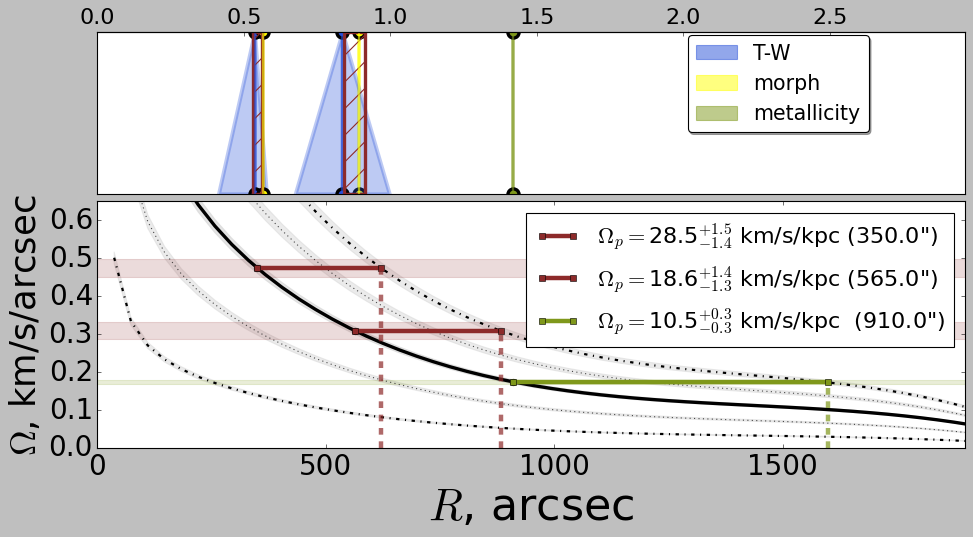

In [39]:
fig = plt.figure(figsize=[14,6.5])
warnings.filterwarnings('ignore')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(5, 5, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:]) 
altname = Ned.query_object('IC0342')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs(altname, axx=ax, legend=True, is_arcsec=True, verbose=False, mode=None, r25=r25_)

#######
ax = fig.add_subplot(gs[2:, 0:]) 
plot_Omega('IC0342','vla',deg=4,ax=ax)
path = './../images/images_RAA/' + 'IC0342'
plt.savefig(path+'_coupling.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 

### M 58

In [40]:
def get_Omega_and_error(gal_name,catalog,deg=None,inkpc=False, islim=False):
    path, Mpc = get_path_and_dist(gal_name,catalog)
    
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
        
    dR = (max(rad) - min(rad)) / 20
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [8.7,26,72]
    cr_l = [8.7,24,65]
    cr_r = [8.7,28,85]
   
         
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,catalog,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        altname = Ned.query_object(gal_name)['Object Name']

        modz = hyp[hyp['name']==altname[0]].modz.to_numpy()
        Mpc = zToMpc(modz)
        if Mpc > 0.:
            scale = math.pi / (180 * 3600) * Mpc * 10**3
            Omega = Omega / scale
            err_l = err_l / scale
            err_r = err_r / scale
            Omega = Omega.tolist()
            err_l = err_l.tolist()
            err_r = err_r.tolist()
            return  Omega, err_l, err_r
        else:
            modz = hyp[hyp['name']==altname[0]].mod0.to_numpy()
            Mpc = zToMpc(modz) 
            if Mpc > 0.:
                scale = math.pi / (180 * 3600) * Mpc * 10**3
                Omega = Omega / scale
                err_l = err_l / scale
                err_r = err_r / scale
                Omega = Omega.tolist()
                err_l = err_l.tolist()
                err_r = err_r.tolist()
                return  Omega, err_l, err_r
            else:

                print('There is no value for distance for galaxy '+gal_name+' in hyperleda')
                return np.zeros(len(Omega)),np.zeros(len(Omega)),np.zeros(len(Omega))


    else:

        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,catalog,deg=None,figsize=None,ax=None): 
    
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
    
    
    cr = [8.7,26,72]
    method = ['potential-density','cross','cross']
 
            
              
    lim  = max(max(rad),4*max(cr))
    points = np.linspace(min(rad), lim, 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    
    dR = (max(rad) - min(rad)) / 20
    
    err = velcurve_error(gal_name,catalog,deg=deg) 
        
    
    
    kappa = [epic_freq(velocity_approx(r), r, dR) for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx(r), r, dR) for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx(r), r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    Omega_kpc, err_l_kpc, err_r_kpc = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=True)
    Omega, err_l, err_r = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=False)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=max(rad)):
                if Omega_kpc[ind] == 0:
                   
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]],
                         label = r'$\Omega_p = $'+str("%.1f" % Omega[ind])+'+'+str("%.1f" % err_r[ind])+'-'+str("%.1f" % err_l[ind])+' км/с/" ('+ str("%.1f" %val)+'")')
                else:
                    array = zip(Omega_kpc,err_l_kpc,err_r_kpc)
                    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                    Omega_kpc = [x[0] for x in array_sort]
                    err_l_kpc = [x[1] for x in array_sort]
                    err_r_kpc = [x[2] for x in array_sort]
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.17,color=method_color[method[ind]])
                         
        
                xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                                 label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc ('+ str("%.1f" %val)+'")')
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                             label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
               
            
        plt.ylim(0,17)
    
        if len(Omega)>2 :
            plt.xlim(0,min(max(points),max(1.1*y_new,1.1*max(cr))))
        elif (len(Omega)<=2) & (y_new==0):
            plt.xlim(0,min(max(points),2.5*max(cr)))    
        elif (len(Omega)<=2) & (y_new!=0):
            plt.xlim(0,min(max(points),1.5*y_new))
            
        
    # ax.fill_between([0, 21], [10,10],color ='#948d8a', hatch='/',facecolor='none', alpha=1)
    # plt.plot([21,40],[40*0.10181087303300256,40*0.10181087303300256],'s-',color='#3c20ff', linewidth = 4)
    
    plt.legend(fontsize=20)
    plt.xlim(0,160)        
    plt.ylabel(f'$\Omega$, km/s/arcsec', fontsize = 32)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=25)
#     path = './images/' + gal_name
#     plt.savefig(path+'_Omega.jpg',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    
method_color = {'F-B' : '#354247',            
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : '#ee4b48',
 'potential-density' : 'cyan',
 'width': '#e6a900',               
 'T-W':  '#2750d9',
 'P-D':'#484032',
 'metallicity': '#7f981b',               
'cross': '#8d2a2a'            
}
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(0.68,0.99), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, axx=None,  legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,4.3])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [8.7,24.7,48,81,71.1,84.9,80.7,26.1,88,81,69.6]
    cr_l = [0,0,0,0,8.4,1.5,17.5,2.4,16,18,6.8]
    cr_r = [0,0,0,0,8.4,1.5,17.5,2.4,16,18,6.8]
    methods = ['potential-density','potential-density','potential-density','potential-density',
               'model','morph','T-W','P-D','offset','offset','width']
    
    
    for i in range(len(cr)):
    
        if mode == 'box':
            ax.axvspan(cr[i]-abs(cr_l[i]),  cr[i]+cr_r[i], alpha=0.5, color=method_color[methods[i]], label=methods[i],linewidth = 1)
        else:
            ax.fill_between([cr[i]-abs(cr_l[i]),  cr[i]], [0, 100.], alpha=0.3, color=method_color[methods[i]], label=methods[i],linewidth = 3.5)
            ax.fill_between([cr[i],  cr[i]+cr_r[i]], [100, 0.], alpha=0.3, color=method_color[methods[i]], label=methods[i],linewidth = 3.5)

        plt.axvline(cr[i],color=method_color[methods[i]],linewidth = 2,alpha=0.6)
        ax.scatter(cr[i], 0, 100, color=method_color[methods[i]], alpha=1, edgecolor='k',linewidth = 3)
        ax.scatter(cr[i], 100, 100, color=method_color[methods[i]], alpha=1, edgecolor='k',linewidth = 3)
        cc+=1
        
    if verbose:
            print('===='*30)
    if len(cr)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
         plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=13.5, used_methods=methods)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')
    
    
    #ax.set_title(altname[0], fontsize=40,pad=40)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    plt.xlim(0,160)
    ax.tick_params(axis='both', which='major', labelsize=23)
        
    ax.fill_between([24, 28], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    ax.fill_between([65, 85], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20) 

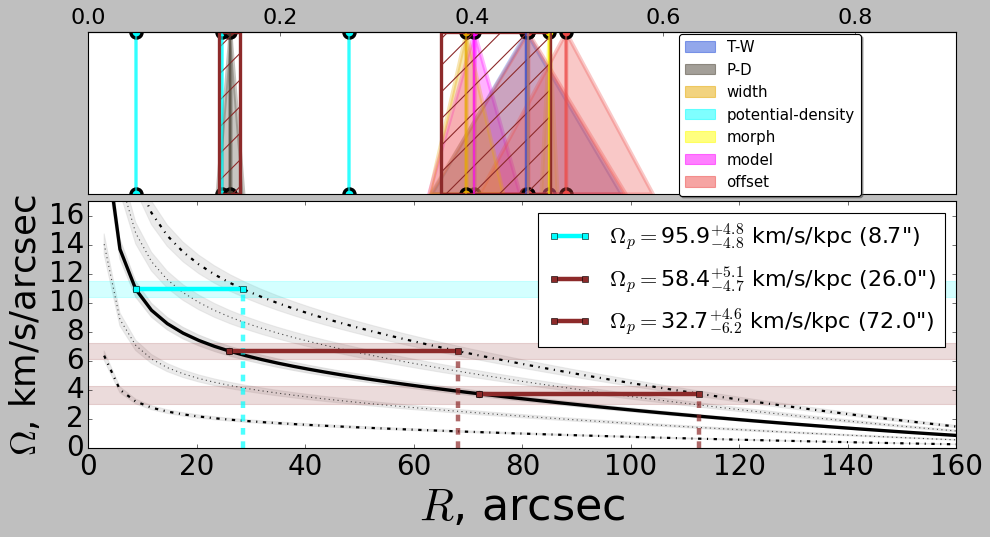

In [41]:
fig = plt.figure(figsize=[14,6.5])
warnings.filterwarnings('ignore')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(5, 5, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:]) 
altname = Ned.query_object('NGC4579')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs(altname, axx=ax, legend=True, is_arcsec=True, verbose=False, mode=None, r25=r25_)

#######
ax = fig.add_subplot(gs[2:, 0:]) 
plot_Omega('NGC4579','phangs',deg=3,ax=ax)
path = './../images/images_RAA/' + 'M58'
plt.savefig(path+'_coupling.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 

### M 74

In [42]:
def get_Omega_and_error(gal_name,catalog,deg=None,inkpc=False, islim=False):
    path, Mpc = get_path_and_dist(gal_name,catalog)
    
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
        
    dR = (max(rad) - min(rad)) / 20
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [85,142]
    cr_l = [78,135]
    cr_r = [95,150]
   
         
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,catalog,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        altname = Ned.query_object(gal_name)['Object Name']

        modz = hyp[hyp['name']==altname[0]].modz.to_numpy()
        Mpc = zToMpc(modz)
        if Mpc > 0.:
            scale = math.pi / (180 * 3600) * Mpc * 10**3
            Omega = Omega / scale
            err_l = err_l / scale
            err_r = err_r / scale
            Omega = Omega.tolist()
            err_l = err_l.tolist()
            err_r = err_r.tolist()
            return  Omega, err_l, err_r
        else:
            modz = hyp[hyp['name']==altname[0]].mod0.to_numpy()
            Mpc = zToMpc(modz) 
            if Mpc > 0.:
                scale = math.pi / (180 * 3600) * Mpc * 10**3
                Omega = Omega / scale
                err_l = err_l / scale
                err_r = err_r / scale
                Omega = Omega.tolist()
                err_l = err_l.tolist()
                err_r = err_r.tolist()
                return  Omega, err_l, err_r
            else:

                print('There is no value for distance for galaxy '+gal_name+' in hyperleda')
                return np.zeros(len(Omega)),np.zeros(len(Omega)),np.zeros(len(Omega))


    else:

        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,catalog,deg=None,figsize=None,ax=None): 
    
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
    
    
    cr = [85,142]
    method = ['cross','cross']
 
            
              
    lim  = max(max(rad),4*max(cr))
    points = np.linspace(min(rad), lim, 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    
    dR = (max(rad) - min(rad)) / 20
    
    err = velcurve_error(gal_name,catalog,deg=deg) 
        
    
    
    kappa = [epic_freq(velocity_approx(r), r, dR) for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx(r), r, dR) for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx(r), r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    Omega_kpc, err_l_kpc, err_r_kpc = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=True)
    Omega, err_l, err_r = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=False)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=max(rad)):
                if Omega_kpc[ind] == 0:
                   
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]],
                         label = r'$\Omega_p = $'+str("%.1f" % Omega[ind])+'+'+str("%.1f" % err_r[ind])+'-'+str("%.1f" % err_l[ind])+' км/с/" ('+ str("%.1f" %val)+'")')
                else:
                    array = zip(Omega_kpc,err_l_kpc,err_r_kpc)
                    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                    Omega_kpc = [x[0] for x in array_sort]
                    err_l_kpc = [x[1] for x in array_sort]
                    err_r_kpc = [x[2] for x in array_sort]
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.17,color=method_color[method[ind]])
                         
        
                xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                                 label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc ('+ str("%.1f" %val)+'")')
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                             label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
               
            
        plt.ylim(0,5.2)
    
        if len(Omega)>2 :
            plt.xlim(0,min(max(points),max(1.1*y_new,1.1*max(cr))))
        elif (len(Omega)<=2) & (y_new==0):
            plt.xlim(0,min(max(points),2.5*max(cr)))    
        elif (len(Omega)<=2) & (y_new!=0):
            plt.xlim(0,min(max(points),1.5*y_new))
            
        
    # ax.fill_between([0, 21], [10,10],color ='#948d8a', hatch='/',facecolor='none', alpha=1)
    # plt.plot([21,40],[40*0.10181087303300256,40*0.10181087303300256],'s-',color='#3c20ff', linewidth = 4)
    
    plt.legend(fontsize=20)
    plt.xlim(0,270)        
    plt.ylabel(f'$\Omega$, km/s/arcsec', fontsize = 32)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=25)
#     path = './images/' + gal_name
#     plt.savefig(path+'_Omega.jpg',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    
method_color = {'F-B' : '#354247',            
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : '#ee4b48',
 'potential-density' : 'cyan',
 'width': '#e6a900',               
 'T-W':  '#2750d9',
 'P-D':'#484032',
 'metallicity': '#7f981b',               
'cross': '#8d2a2a'            
}
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(0.78,0.99), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, axx=None,  legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,4.3])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr_ = []
    methods = []
    for ind, row in df[df['altname']==altname[0]].iterrows():         
        method = row['method'] 
        methods.append(method)
        cr_.append(row['cr'])   
    
        if method == 'spiral':
            for arm_band_ind in range(3):
                try:
                    crs = entry[0]['cr'][name_mapped][arm_band_ind]
                except:
                    continue
                bar_from = 33.3*arm_band_ind
                bar_to = 33.3*(arm_band_ind+1)
                for info in crs:
                    if verbose:
                        print(info, method)
                    cr, arm_color = info
                    #ax.bar(cr, bottom=bar_from, height=(bar_to-bar_from), color='none', edgecolor=arm_color, hatch="/", lw=2)
                    #ax.scatter(cr, (bar_from+bar_to)/2., 100, color=arm_color, edgecolor='k', marker='d', alpha=0.5)
        else:

            cr=row['cr']
            cr_r = row['err_cr_r']
            cr_l = row['err_cr_l']
            mets.append(method)
            
            if verbose:
                print(info, method)
            
            
            if method == 'SNs':
                ax.scatter(cr, 50, 100, color=method_color[method], label=method)
    #           ax.scatter(cr, 50, 100, color=method_color[method], label=method, marker='+')
            else:
                if mode == 'box':
                    ax.axvspan(cr-abs(cr_l),  cr+cr_r, alpha=0.5, color=method_color[method], label=method,linewidth = 1)
                else:
                    ax.fill_between([cr-abs(cr_l),  cr], [0, 100.], alpha=0.4, color=method_color[method], label=method,linewidth = 2)
                    ax.fill_between([cr,  cr+cr_r], [100, 0.], alpha=0.4, color=method_color[method], label=method,linewidth = 3)
                        
                ax.scatter(cr, 0, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                ax.scatter(cr, 100, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                cc+=1
        
    if verbose:
            print('===='*30)
    if len(cr_)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
         plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=16.5, used_methods=methods)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')
    
    
    #ax.set_title(altname[0], fontsize=40,pad=40)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    plt.xlim(0,270)
    ax.tick_params(axis='both', which='major', labelsize=23)
        
    ax.fill_between([78, 95], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    ax.fill_between([135, 150], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20) 

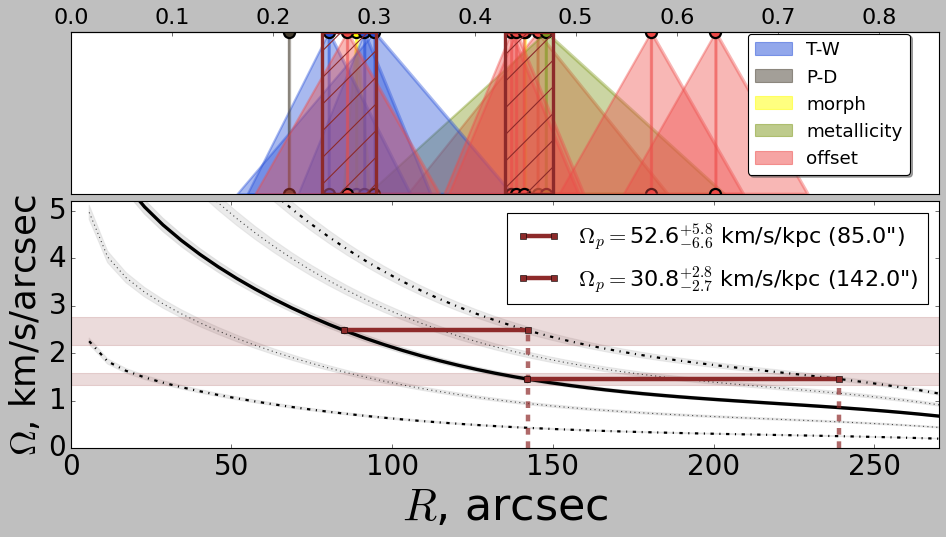

In [43]:
fig = plt.figure(figsize=[14,6.5])
warnings.filterwarnings('ignore')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(5, 5, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:]) 
altname = Ned.query_object('NGC628')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs(altname, axx=ax, legend=True, is_arcsec=True, verbose=False, mode=None, r25=r25_)

#######
ax = fig.add_subplot(gs[2:, 0:]) 
plot_Omega('NGC628','things',deg=4,ax=ax)
path = './../images/images_RAA/' + 'M74'
plt.savefig(path+'_coupling.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 

### NGC 3583

In [44]:
def get_Omega_and_error(gal_name,catalog,deg=None,inkpc=False, islim=False):
    path, Mpc = get_path_and_dist(gal_name,catalog)
    
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
        
    dR = (max(rad) - min(rad)) / 20
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [33,64.6]
    cr_l = [30,64.6]
    cr_r = [35,64.6]
   
         
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,catalog,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        altname = Ned.query_object(gal_name)['Object Name']

        modz = hyp[hyp['name']==altname[0]].modz.to_numpy()
        Mpc = zToMpc(modz)
        if Mpc > 0.:
            scale = math.pi / (180 * 3600) * Mpc * 10**3
            Omega = Omega / scale
            err_l = err_l / scale
            err_r = err_r / scale
            Omega = Omega.tolist()
            err_l = err_l.tolist()
            err_r = err_r.tolist()
            return  Omega, err_l, err_r
        else:
            modz = hyp[hyp['name']==altname[0]].mod0.to_numpy()
            Mpc = zToMpc(modz) 
            if Mpc > 0.:
                scale = math.pi / (180 * 3600) * Mpc * 10**3
                Omega = Omega / scale
                err_l = err_l / scale
                err_r = err_r / scale
                Omega = Omega.tolist()
                err_l = err_l.tolist()
                err_r = err_r.tolist()
                return  Omega, err_l, err_r
            else:

                print('There is no value for distance for galaxy '+gal_name+' in hyperleda')
                return np.zeros(len(Omega)),np.zeros(len(Omega)),np.zeros(len(Omega))


    else:

        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,catalog,deg=None,figsize=None,ax=None): 
    
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    vel = np.concatenate([[0.0], vel])
    rad = np.concatenate([[0.0], rad])
    
    
    cr = [33,64.6]
    method = ['cross','potential-density']
 
            
              
    lim  = max(max(rad),4*max(cr))
    points = np.linspace(min(rad), lim, 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    
    dR = (max(rad) - min(rad)) / 20
    
    err = velcurve_error(gal_name,catalog,deg=deg) 
        
    
    
    kappa = [epic_freq(velocity_approx(r), r, dR) for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx(r), r, dR) for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx(r), r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    Omega_kpc, err_l_kpc, err_r_kpc = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=True)
    Omega, err_l, err_r = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=False)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=max(rad)):
                if Omega_kpc[ind] == 0:
                   
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]],
                         label = r'$\Omega_p = $'+str("%.1f" % Omega[ind])+'+'+str("%.1f" % err_r[ind])+'-'+str("%.1f" % err_l[ind])+' км/с/" ('+ str("%.1f" %val)+'")')
                else:
                    array = zip(Omega_kpc,err_l_kpc,err_r_kpc)
                    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                    Omega_kpc = [x[0] for x in array_sort]
                    err_l_kpc = [x[1] for x in array_sort]
                    err_r_kpc = [x[2] for x in array_sort]
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.17,color=method_color[method[ind]])
                         
        
                xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                                 label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc ('+ str("%.1f" %val)+'")')
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                             label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
               
            
        plt.ylim(0,13)
    
        if len(Omega)>2 :
            plt.xlim(0,min(max(points),max(1.1*y_new,1.1*max(cr))))
        elif (len(Omega)<=2) & (y_new==0):
            plt.xlim(0,min(max(points),2.5*max(cr)))    
        elif (len(Omega)<=2) & (y_new!=0):
            plt.xlim(0,min(max(points),1.5*y_new))
            
        
    # ax.fill_between([0, 21], [10,10],color ='#948d8a', hatch='/',facecolor='none', alpha=1)
    # plt.plot([21,40],[40*0.10181087303300256,40*0.10181087303300256],'s-',color='#3c20ff', linewidth = 4)
    
    plt.legend(fontsize=20)
    plt.xlim(0,110)        
    plt.ylabel(f'$\Omega$, km/s/arcsec', fontsize = 32)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=25)
#     path = './images/' + gal_name
#     plt.savefig(path+'_Omega.jpg',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    
method_color = {'F-B' : '#354247',            
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : '#ee4b48',
 'potential-density' : 'cyan',
 'widths': '#e6a900',               
 'T-W':  '#2750d9',
 'P-D':'#484032',
 'metallicity': '#7f981b',               
'cross': '#8d2a2a'            
}
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(0.72,0.99), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, axx=None,  legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,4.3])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr_ = []
    methods = []
    for ind, row in df[df['altname']==altname[0]].iterrows():         
        method = row['method'] 
        methods.append(method)
        cr_.append(row['cr'])   
    
        if method == 'spiral':
            for arm_band_ind in range(3):
                try:
                    crs = entry[0]['cr'][name_mapped][arm_band_ind]
                except:
                    continue
                bar_from = 33.3*arm_band_ind
                bar_to = 33.3*(arm_band_ind+1)
                for info in crs:
                    if verbose:
                        print(info, method)
                    cr, arm_color = info
                    #ax.bar(cr, bottom=bar_from, height=(bar_to-bar_from), color='none', edgecolor=arm_color, hatch="/", lw=2)
                    #ax.scatter(cr, (bar_from+bar_to)/2., 100, color=arm_color, edgecolor='k', marker='d', alpha=0.5)
        else:

            cr=row['cr']
            cr_r = row['err_cr_r']
            cr_l = row['err_cr_l']
            mets.append(method)
            
            if verbose:
                print(info, method)
            
            
            if method == 'SNs':
                ax.scatter(cr, 50, 100, color=method_color[method], label=method)
    #           ax.scatter(cr, 50, 100, color=method_color[method], label=method, marker='+')
            else:
                if mode == 'box':
                    ax.axvspan(cr-abs(cr_l),  cr+cr_r, alpha=0.5, color=method_color[method], label=method,linewidth = 1)
                else:
                    ax.fill_between([cr-abs(cr_l),  cr], [0, 100.], alpha=0.4, color=method_color[method], label=method,linewidth = 2)
                    ax.fill_between([cr,  cr+cr_r], [100, 0.], alpha=0.4, color=method_color[method], label=method,linewidth = 3)
                        
                ax.scatter(cr, 0, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                ax.scatter(cr, 100, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                cc+=1
        
    if verbose:
            print('===='*30)
    if len(cr_)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
         plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=16.5, used_methods=methods)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')
    
    
    #ax.set_title(altname[0], fontsize=40,pad=40)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    plt.xlim(0,110)
    ax.tick_params(axis='both', which='major', labelsize=23)
        
    ax.fill_between([30, 35], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20) 

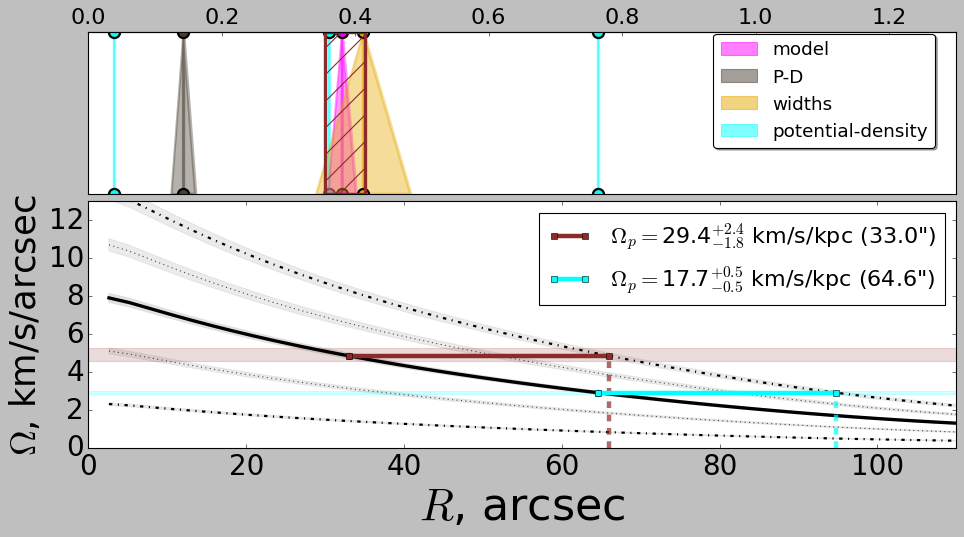

In [45]:
fig = plt.figure(figsize=[14,6.5])
warnings.filterwarnings('ignore')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(5, 5, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:]) 
altname = Ned.query_object('NGC3583')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs(altname, axx=ax, legend=True, is_arcsec=True, verbose=False, mode=None, r25=r25_)

#######
ax = fig.add_subplot(gs[2:, 0:]) 
plot_Omega('UGC6263','whisp',deg=6,ax=ax)
path = './../images/images_RAA/' + 'NGC3583'
plt.savefig(path+'_coupling.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 

### NGC 5371

In [46]:
def get_Omega_and_error(gal_name,catalog,deg=None,inkpc=False, islim=False):
    path, Mpc = get_path_and_dist(gal_name,catalog)
    
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    # vel = np.concatenate([[0.0], vel])
    # rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
        
    dR = (max(rad) - min(rad)) / 20
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [44,81]
    cr_l = [42,78]
    cr_r = [46,84]
   
         
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,catalog,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        altname = Ned.query_object(gal_name)['Object Name']

        modz = hyp[hyp['name']==altname[0]].modz.to_numpy()
        Mpc = zToMpc(modz)
        if Mpc > 0.:
            scale = math.pi / (180 * 3600) * Mpc * 10**3
            Omega = Omega / scale
            err_l = err_l / scale
            err_r = err_r / scale
            Omega = Omega.tolist()
            err_l = err_l.tolist()
            err_r = err_r.tolist()
            return  Omega, err_l, err_r
        else:
            modz = hyp[hyp['name']==altname[0]].mod0.to_numpy()
            Mpc = zToMpc(modz) 
            if Mpc > 0.:
                scale = math.pi / (180 * 3600) * Mpc * 10**3
                Omega = Omega / scale
                err_l = err_l / scale
                err_r = err_r / scale
                Omega = Omega.tolist()
                err_l = err_l.tolist()
                err_r = err_r.tolist()
                return  Omega, err_l, err_r
            else:

                print('There is no value for distance for galaxy '+gal_name+' in hyperleda')
                return np.zeros(len(Omega)),np.zeros(len(Omega)),np.zeros(len(Omega))


    else:

        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,catalog,deg=None,figsize=None,ax=None): 
    
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    # vel = np.concatenate([[0.0], vel])
    # rad = np.concatenate([[0.0], rad])
    
    
    cr = [44,81]
    method = ['cross','cross']
 
            
              
    lim  = max(max(rad),4*max(cr))
    points = np.linspace(min(rad), lim, 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    
    dR = (max(rad) - min(rad)) / 20
    
    err = velcurve_error(gal_name,catalog,deg=deg) 
        
    
    
    kappa = [epic_freq(velocity_approx(r), r, dR) for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx(r), r, dR) for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx(r), r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    Omega_kpc, err_l_kpc, err_r_kpc = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=True)
    Omega, err_l, err_r = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=False)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=max(rad)):
                if Omega_kpc[ind] == 0:
                   
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]],
                         label = r'$\Omega_p = $'+str("%.1f" % Omega[ind])+'+'+str("%.1f" % err_r[ind])+'-'+str("%.1f" % err_l[ind])+' км/с/" ('+ str("%.1f" %val)+'")')
                else:
                    array = zip(Omega_kpc,err_l_kpc,err_r_kpc)
                    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                    Omega_kpc = [x[0] for x in array_sort]
                    err_l_kpc = [x[1] for x in array_sort]
                    err_r_kpc = [x[2] for x in array_sort]
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.17,color=method_color[method[ind]])
                         
        
                xx,yy = np.array(omega)+np.array(kappa)/2., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                                 label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc ('+ str("%.1f" %val)+'")')
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                             label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
               
            
        plt.ylim(0,10.5)
    
        if len(Omega)>2 :
            plt.xlim(0,min(max(points),max(1.1*y_new,1.1*max(cr))))
        elif (len(Omega)<=2) & (y_new==0):
            plt.xlim(0,min(max(points),2.5*max(cr)))    
        elif (len(Omega)<=2) & (y_new!=0):
            plt.xlim(0,min(max(points),1.5*y_new))
            
        
    # ax.fill_between([0, 21], [10,10],color ='#948d8a', hatch='/',facecolor='none', alpha=1)
    # plt.plot([21,40],[40*0.10181087303300256,40*0.10181087303300256],'s-',color='#3c20ff', linewidth = 4)
    
    plt.legend(fontsize=20)
    plt.xlim(0,150)        
    plt.ylabel(f'$\Omega$, km/s/arcsec', fontsize = 32)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=25)
#     path = './images/' + gal_name
#     plt.savefig(path+'_Omega.jpg',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    
method_color = {'F-B' : '#354247',            
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : '#ee4b48',
 'potential-density' : 'cyan',
 'widths': '#e6a900',               
 'T-W':  '#2750d9',
 'P-D':'#484032',
 'metallicity': '#7f981b',               
'cross': '#8d2a2a'            
}
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(0.72,0.99), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, axx=None,  legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,4.3])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr_ = []
    methods = []
    for ind, row in df[df['altname']==altname[0]].iterrows():         
        method = row['method'] 
        methods.append(method)
        cr_.append(row['cr'])   
    
        if method == 'spiral':
            for arm_band_ind in range(3):
                try:
                    crs = entry[0]['cr'][name_mapped][arm_band_ind]
                except:
                    continue
                bar_from = 33.3*arm_band_ind
                bar_to = 33.3*(arm_band_ind+1)
                for info in crs:
                    if verbose:
                        print(info, method)
                    cr, arm_color = info
                    #ax.bar(cr, bottom=bar_from, height=(bar_to-bar_from), color='none', edgecolor=arm_color, hatch="/", lw=2)
                    #ax.scatter(cr, (bar_from+bar_to)/2., 100, color=arm_color, edgecolor='k', marker='d', alpha=0.5)
        else:

            cr=row['cr']
            cr_r = row['err_cr_r']
            cr_l = row['err_cr_l']
            mets.append(method)
            
            if verbose:
                print(info, method)
            
            
            if method == 'SNs':
                ax.scatter(cr, 50, 100, color=method_color[method], label=method)
    #           ax.scatter(cr, 50, 100, color=method_color[method], label=method, marker='+')
            else:
                if mode == 'box':
                    ax.axvspan(cr-abs(cr_l),  cr+cr_r, alpha=0.5, color=method_color[method], label=method,linewidth = 1)
                else:
                    ax.fill_between([cr-abs(cr_l),  cr], [0, 100.], alpha=0.4, color=method_color[method], label=method,linewidth = 2)
                    ax.fill_between([cr,  cr+cr_r], [100, 0.], alpha=0.4, color=method_color[method], label=method,linewidth = 3)
                        
                ax.scatter(cr, 0, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                ax.scatter(cr, 100, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                cc+=1
        
    if verbose:
            print('===='*30)
    if len(cr_)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
         plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=16.5, used_methods=methods)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')
    
    
    #ax.set_title(altname[0], fontsize=40,pad=40)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    plt.xlim(0,150)
    ax.tick_params(axis='both', which='major', labelsize=23)
        
    ax.fill_between([42, 46], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    ax.fill_between([78, 84], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20) 

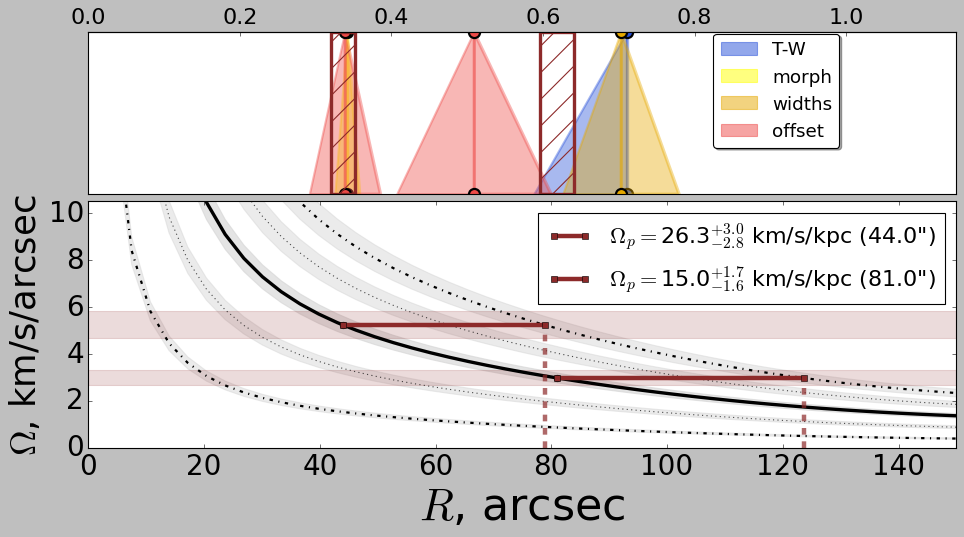

In [47]:
fig = plt.figure(figsize=[14,6.5])
warnings.filterwarnings('ignore')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(5, 5, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:]) 
altname = Ned.query_object('NGC5371')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs(altname, axx=ax, legend=True, is_arcsec=True, verbose=False, mode=None, r25=r25_)

#######
ax = fig.add_subplot(gs[2:, 0:]) 
plot_Omega('NGC5371','sparc',deg=5,ax=ax)
path = './images_RAA/' + 'NGC5371'
plt.savefig(path+'_coupling.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 

In [58]:
def get_Omega_and_error(gal_name,catalog,deg=None,inkpc=False, islim=False):
    path, Mpc = get_path_and_dist(gal_name,catalog)
    
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    # vel = np.concatenate([[0.0], vel])
    # rad = np.concatenate([[0.0], rad])

    points = np.linspace(min(rad)+1, max(rad), 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
        
    dR = (max(rad) - min(rad)) / 20
    omega = [v/r for r,v in zip(points, velocity_approx(points))]
    
    altname = Ned.query_object(gal_name)['Object Name']
    
    cr = [45,66,92]
    cr_l = [43,64,90]
    cr_r = [47,68,94]
   
         
    Omega = []
    Omega_l = []
    Omega_r = []
    vel_err = velcurve_error(gal_name,catalog,deg=deg) 

    if islim:
        for i, r in enumerate(cr):
            if(r<=max(rad)):
                errors=[]
                Omega.append(velocity_approx(r)/r)
                errors.append(velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
                errors.append(velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
                Omega_l.append(np.min(errors))
                Omega_r.append(np.max(errors))
    else:
        for i, r in enumerate(cr):
            errors=[]
            Omega.append(velocity_approx(r)/r)
            errors.append(velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.+vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append((1.-vel_err)*velocity_approx(cr_l[i])/cr_l[i])
            errors.append(velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.+vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            errors.append((1.-vel_err)*velocity_approx(cr_r[i])/cr_r[i])
            Omega_l.append(np.min(errors))
            Omega_r.append(np.max(errors))

    err_l = [Omega[i] - Omega_l[i] for i in range(len(Omega))]
    err_r =  [Omega_r[i] - Omega[i] for i in range(len(Omega))]

    if inkpc:
        altname = Ned.query_object(gal_name)['Object Name']

        modz = hyp[hyp['name']==altname[0]].modz.to_numpy()
        Mpc = zToMpc(modz)
        if Mpc > 0.:
            scale = math.pi / (180 * 3600) * Mpc * 10**3
            Omega = Omega / scale
            err_l = err_l / scale
            err_r = err_r / scale
            Omega = Omega.tolist()
            err_l = err_l.tolist()
            err_r = err_r.tolist()
            return  Omega, err_l, err_r
        else:
            modz = hyp[hyp['name']==altname[0]].mod0.to_numpy()
            Mpc = zToMpc(modz) 
            if Mpc > 0.:
                scale = math.pi / (180 * 3600) * Mpc * 10**3
                Omega = Omega / scale
                err_l = err_l / scale
                err_r = err_r / scale
                Omega = Omega.tolist()
                err_l = err_l.tolist()
                err_r = err_r.tolist()
                return  Omega, err_l, err_r
            else:

                print('There is no value for distance for galaxy '+gal_name+' in hyperleda')
                return np.zeros(len(Omega)),np.zeros(len(Omega)),np.zeros(len(Omega))


    else:

        return  Omega, err_l, err_r
            
def plot_Omega(gal_name,catalog,deg=None,figsize=None,ax=None): 
    
    path, Mpc = get_path_and_dist(gal_name,catalog)
     
    data = np.loadtxt(path + '.dat')
    
    vel = np.abs(data[:,1])
    rad = np.abs(data[:,0])
    
    if Mpc is not None:
        scale = np.pi / (180 * 3600) * Mpc * 10**3
        rad = rad/scale
    
    # vel = np.concatenate([[0.0], vel])
    # rad = np.concatenate([[0.0], rad])
    
    
    cr = [45,66,92]
    method = ['cross','offset','cross']
 
            
              
    lim  = max(max(rad),4*max(cr))
    points = np.linspace(min(rad), lim, 100)
    if deg is None:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=7))
    else:
        velocity_approx = np.poly1d(np.polyfit(rad, vel, deg=deg))
    
    
    dR = (max(rad) - min(rad)) / 20
    
    err = velcurve_error(gal_name,catalog,deg=deg) 
        
    
    
    kappa = [epic_freq(velocity_approx(r), r, dR) for r in points]
    kappa_l = [epic_freq((1.-err)*velocity_approx(r), r, dR) for r in points]
    kappa_r = [epic_freq((1.+err)*velocity_approx(r), r, dR) for r in points]
    
    omega = [v/r for r,v in zip(points, velocity_approx(points))] 
    omega_l = [v/r for r,v in zip(points, (1.-err)*velocity_approx(points))]  
    omega_r = [v/r for r,v in zip(points, (1.+err)*velocity_approx(points))]  
      
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if ax is not None:
        ax = ax
        
    plt.plot(points, omega, color='k',linewidth=3)
    plt.fill_between(points,omega_l, omega_r, alpha=0.6,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/2., np.array(omega_r)-np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/2.,'-.', color='k',linewidth=2)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/2., np.array(omega_r)+np.array(kappa_r)/2., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)-np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points, np.array(omega_l)-np.array(kappa_l)/4., np.array(omega_r)-np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    plt.plot(points, np.array(omega)+np.array(kappa)/4., ':', color='k', alpha=0.7)
    plt.fill_between(points,np.array(omega_l)+np.array(kappa_l)/4., np.array(omega_r)+np.array(kappa_r)/4., alpha=0.45,color='lightgray')
    
    Omega_kpc, err_l_kpc, err_r_kpc = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=True)
    Omega, err_l, err_r = get_Omega_and_error(gal_name,catalog,deg=deg,inkpc=False)
            
    if len(cr) != 0:
        array = zip(Omega,err_l,err_r, cr, method)
        array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
        Omega = [x[0] for x in array_sort]
        err_l = [x[1] for x in array_sort]
        err_r = [x[2] for x in array_sort]
        cr = [x[3] for x in array_sort]
        method = [x[4] for x in array_sort]
        y_new=0
        
        for ind,val in enumerate(cr):
            if (val<=max(rad)):
                if Omega_kpc[ind] == 0:
                   
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]],
                         label = r'$\Omega_p = $'+str("%.1f" % Omega[ind])+'+'+str("%.1f" % err_r[ind])+'-'+str("%.1f" % err_l[ind])+' км/с/" ('+ str("%.1f" %val)+'")')
                else:
                    array = zip(Omega_kpc,err_l_kpc,err_r_kpc)
                    array_sort = sorted(array, key=lambda tup: tup[0],reverse=True)
                    Omega_kpc = [x[0] for x in array_sort]
                    err_l_kpc = [x[1] for x in array_sort]
                    err_r_kpc = [x[2] for x in array_sort]
                    plt.plot([val], [Omega[ind]], 'o',color=method_color[method[ind]])
                
                plt.axhspan(Omega[ind]-err_l[ind],Omega[ind]+err_r[ind], alpha=0.17,color=method_color[method[ind]])
                         
        
                xx,yy = np.array(omega)+np.array(kappa)/4., points
                indxs = np.isfinite(xx)
                xx,yy = xx[indxs], yy[indxs]

                shapely_line = LineString([[y,x] for x,y in zip(xx, yy)])
                hor_line = LineString([[-1000, Omega[ind]], [1000, Omega[ind]]])
                intersection_line = shapely_line.intersection(hor_line)
            
                try:
                    if len(intersection_line.coords) != 0:
                        if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                        else:
                            y_new = intersection_line.xy[0][0]
                
                        plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                                 label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc ('+ str("%.1f" %val)+'")')
                        plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                except:
                    if type(intersection_line) == shapely.geometry.multipoint.MultiPoint:
                            y_new = [(pt.x, pt.y) for pt in intersection_line][1][0]
                    else:
                            y_new = intersection_line.xy[0][0]
                
                    plt.plot([val, y_new], [Omega[ind], Omega[ind]], 's-', mec='k',color=method_color[method[ind]],linewidth = 4,
                             label = r'$\Omega_p = $'+str("%.1f" % Omega_kpc[ind])+'$^{+'+str("%.1f" % err_r_kpc[ind])+'}_{-'+str("%.1f" % err_l_kpc[ind])+'}$ km/s/kpc  ('+ str("%.1f" %val)+'")')
                    plt.plot([y_new, y_new], [0, Omega[ind]], '--', alpha=0.7,color=method_color[method[ind]],linewidth = 4) 
                
               
            
        plt.ylim(0,10.5)
    
        if len(Omega)>2 :
            plt.xlim(0,min(max(points),max(1.1*y_new,1.1*max(cr))))
        elif (len(Omega)<=2) & (y_new==0):
            plt.xlim(0,min(max(points),2.5*max(cr)))    
        elif (len(Omega)<=2) & (y_new!=0):
            plt.xlim(0,min(max(points),1.5*y_new))
            
        
    # ax.fill_between([0, 21], [10,10],color ='#948d8a', hatch='/',facecolor='none', alpha=1)
    # plt.plot([21,40],[40*0.10181087303300256,40*0.10181087303300256],'s-',color='#3c20ff', linewidth = 4)
    
    plt.legend(fontsize=20)
    plt.xlim(0,150)        
    plt.ylabel(f'$\Omega$, km/s/arcsec', fontsize = 32)
    plt.xlabel(f'$R$, arcsec', fontsize = 40) 
    plt.tick_params(axis='both', which='major',labelsize=25)
#     path = './images/' + gal_name
#     plt.savefig(path+'_Omega.jpg',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05)
    
    
method_color = {'F-B' : '#354247',            
 'model' : 'magenta',
 'morph' : 'yellow',
 'offset' : '#ee4b48',
 'potential-density' : 'cyan',
 'widths': '#e6a900',               
 'T-W':  '#2750d9',
 'P-D':'#484032',
 'metallicity': '#7f981b',               
'cross': '#8d2a2a'            
}
def plot_cr_colorlegend(gal_name=None, ax=None, loc=None, fontsize=None, used_methods=None):
    if used_methods is None:
        methods = []
        for ind, row in df.iterrows():
            methods.append(row['method'])
        methods = set(methods)
    else:
        methods = set(used_methods)
    patches = []
    
    for method in methods:
        patch = mpatches.Patch(color=method_color[method], label=method, alpha=0.5)
        patches.append(patch)
    if fontsize is None:
        ax.legend(handles=patches, loc=loc)
        ax.legend(handles=patches, bbox_to_anchor=(1.01,1.2), loc="upper left", 
          fancybox=True, shadow=True, ncol=1)
    else:
        ax.legend(handles=patches, loc="lower right")
        ax.legend(handles=patches, bbox_to_anchor=(0.72,0.99), loc="upper left", fontsize=fontsize,
          fancybox=True, shadow=True, ncol=1, borderaxespad=0.)
        
def plot_crs(gal_name, axx=None,  legend=True, is_arcsec=False, verbose=False, mode='box', r25=None):
    
    if axx is None:
        fig = plt.figure(figsize=[12,4.3])
        ax = plt.gca()
    else:
        ax = axx
        
    ylim = 0
    xlim = 0
    
    ylim_ = 1e10
    xlim_ = 1e10
    
    mets = []
    cc = 0 
    
    altname = Ned.query_object(gal_name)['Object Name']
    cr_ = []
    methods = []
    for ind, row in df[df['altname']==altname[0]].iterrows():         
        method = row['method'] 
        methods.append(method)
        cr_.append(row['cr'])   
    
        if method == 'spiral':
            for arm_band_ind in range(3):
                try:
                    crs = entry[0]['cr'][name_mapped][arm_band_ind]
                except:
                    continue
                bar_from = 33.3*arm_band_ind
                bar_to = 33.3*(arm_band_ind+1)
                for info in crs:
                    if verbose:
                        print(info, method)
                    cr, arm_color = info
                    #ax.bar(cr, bottom=bar_from, height=(bar_to-bar_from), color='none', edgecolor=arm_color, hatch="/", lw=2)
                    #ax.scatter(cr, (bar_from+bar_to)/2., 100, color=arm_color, edgecolor='k', marker='d', alpha=0.5)
        else:

            cr=row['cr']
            cr_r = row['err_cr_r']
            cr_l = row['err_cr_l']
            mets.append(method)
            
            if verbose:
                print(info, method)
            
            
            if method == 'SNs':
                ax.scatter(cr, 50, 100, color=method_color[method], label=method)
    #           ax.scatter(cr, 50, 100, color=method_color[method], label=method, marker='+')
            else:
                if mode == 'box':
                    ax.axvspan(cr-abs(cr_l),  cr+cr_r, alpha=0.5, color=method_color[method], label=method,linewidth = 1)
                else:
                    ax.fill_between([cr-abs(cr_l),  cr], [0, 100.], alpha=0.4, color=method_color[method], label=method,linewidth = 2)
                    ax.fill_between([cr,  cr+cr_r], [100, 0.], alpha=0.4, color=method_color[method], label=method,linewidth = 3)
                        
                ax.scatter(cr, 0, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                ax.scatter(cr, 100, 100, color=method_color[method], alpha=1, edgecolor='k',linewidth = 2)
                cc+=1
        
    if verbose:
            print('===='*30)
    if len(cr_)==0:
        if verbose:
            print(f'Gal {gal_name} not in entry {ind} ({row["method"]} / {row["link"]}), continue...')
            
    if legend:
         plot_cr_colorlegend(gal_name, ax, loc='lower right', fontsize=18.5, used_methods=methods)   
    
    if verbose:
           print(f'Gal {gal_name} IN entry {ind} ({row["method"]} / {row["link"]}):')
    
    
    #ax.set_title(altname[0], fontsize=40,pad=40)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor('white')
        
    ax.set_ylim(0, 100)
    plt.xlim(0,150)
    ax.tick_params(axis='both', which='major', labelsize=23)
        
    ax.fill_between([43, 47], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    ax.fill_between([90, 94], [100,100],color ='#8d2a2a', hatch='/',facecolor='none', alpha=1, linewidth = 3)
    
    if r25 is not None:
        
        def to_new_axis(x):
            return x/r25
        
        def from_new_axis(x):
            return x*r25
        
        secax = ax.secondary_xaxis('top', functions=(to_new_axis, from_new_axis))
        secax.tick_params(axis='both', which='major', labelsize=20) 

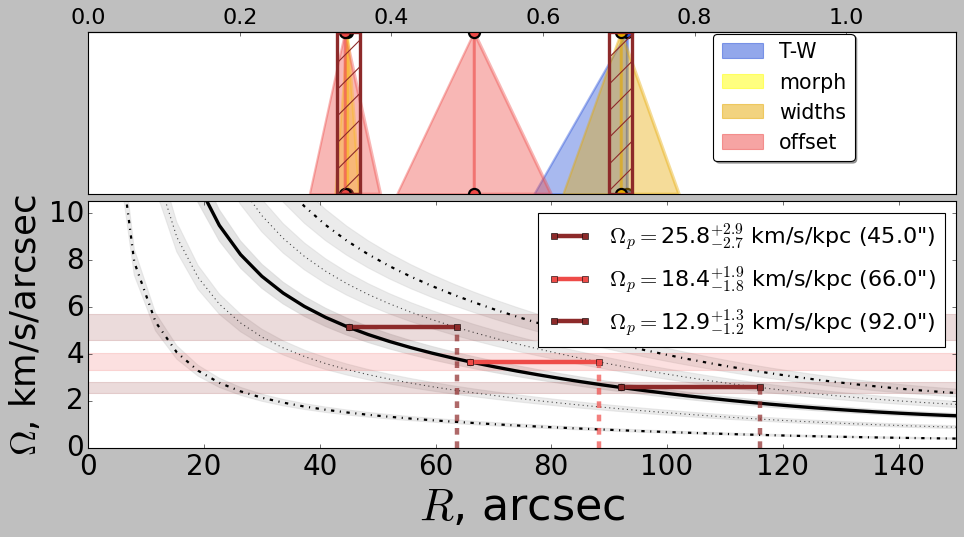

In [59]:
fig = plt.figure(figsize=[14,6.5])
warnings.filterwarnings('ignore')
plt.subplots_adjust(wspace=0.05, hspace=0.1)

gs = GridSpec(5, 5, figure=fig)

ax = fig.add_subplot(gs[0:2, 0:]) 
altname = Ned.query_object('NGC5371')['Object Name'][0]    
for ind, row in df[df['altname']==altname].iterrows():
    r25_=row['r25_NED']

plot_crs(altname, axx=ax, legend=True, is_arcsec=True, verbose=False, mode=None, r25=r25_)

#######
ax = fig.add_subplot(gs[2:, 0:]) 
plot_Omega('NGC5371','sparc',deg=5,ax=ax)
path = './../images/images_RAA/' + 'NGC5371'
plt.savefig(path+'_coupling.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 

### Winding time $\tau_{wind}$

In [71]:
delta_Omega = [28.5-18.6, 18.6-10.5, 95.9-58.4, 58.4-32.7, 52.6-30.8, 29.4-17.7, 25.8-18.4, 18.4-12.9]
delta_Omega_l = [26.2-20.6, 16.8-10.8, 92.1-62.9, 54.3-36.9,45.5-33.9, 27.6-18.2, 24.3-19.3, 17.6-14.2]
delta_Omega_r = [30.9-16.8, 20.6-10.2, 99.7-54.3, 62.9-27.8, 58.9-27.8,31.8-17.2, 26.7-17.6, 19.3-11.7]
Omega_max = [28.5, 18.6, 95.9, 58.4, 52.6, 29.4, 26.3, 25.8, 18.4]
Omega_max_r = [30.9, 20.6, 99.7, 62.9, 58.9, 31.8, 29.3, 26.7, 19.3]
Omega_max_l = [26.2, 16.8, 92.1, 54.3, 45.5, 27.6, 23.5, 24.3, 17.6]
Omega_min = [18.6, 10.5, 58.4, 32.7, 30.8, 17.7, 15, 18.4, 12.9]
Omega_min_l = [16.8, 10.2, 54.3, 27.8, 27.8, 17.2, 13.4, 17.6, 11.7]
Omega_min_r = [20.6, 10.8, 62.9, 36.9, 33.9, 18.2, 16.7, 19.3, 14.7]

In [72]:
from astropy import units as u

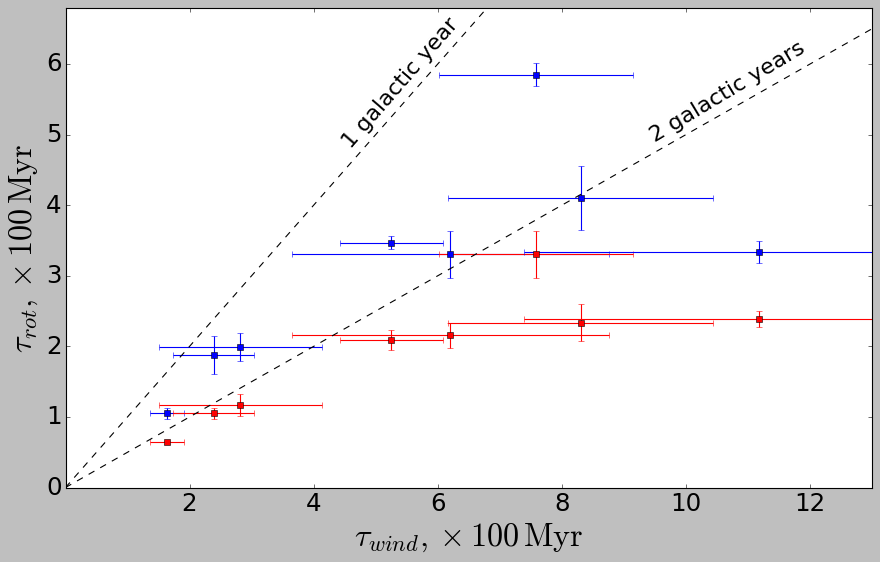

In [79]:
fig = plt.figure(figsize=[13,7.5])
for ind, val in enumerate(delta_Omega):
    
    tau_wind_ = 2.*np.pi/val
    tau_wind_l_ = 2.*np.pi/delta_Omega_l[ind]
    tau_wind_r_ = 2.*np.pi/delta_Omega_r[ind]
    tau_wind = ((tau_wind_*u.kpc.to(u.km)).real*u.second).to(u.year)
    tau_wind_l = ((tau_wind_l_*u.kpc.to(u.km)).real*u.second).to(u.year)
    tau_wind_r = ((tau_wind_r_*u.kpc.to(u.km)).real*u.second).to(u.year)
    
    tau_wind_err = np.sqrt((tau_wind - tau_wind_l)**2 + (tau_wind_r-tau_wind)**2)/2/10**8
    
    
    tau_wind1_ = 2.*np.pi/Omega_max[ind]
    tau_wind1_l_ = 2.*np.pi/Omega_max_l[ind]
    tau_wind1_r_ = 2.*np.pi/Omega_max_r[ind]
    tau_wind1 = ((tau_wind1_*u.kpc.to(u.km)).real*u.second).to(u.year)
    tau_wind1_l = ((tau_wind1_l_*u.kpc.to(u.km)).real*u.second).to(u.year)
    tau_wind1_r = ((tau_wind1_r_*u.kpc.to(u.km)).real*u.second).to(u.year)
    
    tau_wind1_err = (np.abs(tau_wind1 - tau_wind1_l) + np.abs(tau_wind1_r-tau_wind1))/2/10**8
    
    tau_wind2_ = 2.*np.pi/Omega_min[ind]
    tau_wind2_l_ = 2.*np.pi/Omega_min_l[ind]
    tau_wind2_r_ = 2.*np.pi/Omega_min_r[ind]
    tau_wind2 = ((tau_wind2_*u.kpc.to(u.km)).real*u.second).to(u.year)
    tau_wind2_l = ((tau_wind2_l_*u.kpc.to(u.km)).real*u.second).to(u.year)
    tau_wind2_r = ((tau_wind2_r_*u.kpc.to(u.km)).real*u.second).to(u.year)
    
    tau_wind2_err = (np.abs(tau_wind2 - tau_wind2_l) + np.abs(tau_wind2_r-tau_wind2))/2/10**8
    
    
    plt.errorbar(tau_wind/10**8, tau_wind1/10**8, xerr = tau_wind_err, yerr = tau_wind1_err, marker='s', color='red' )
    plt.errorbar(tau_wind/10**8, tau_wind2/10**8, xerr = tau_wind_err, yerr = tau_wind2_err, marker='s', color='blue' )
    
plt.tick_params(axis='both', which='major',labelsize=22)
plt.xlabel(r'$\tau_{wind}, \times 100\, \mathrm{Myr}$', fontsize=29)
plt.ylabel(r'$\tau_{rot}, \times 100\, \mathrm{Myr}$', fontsize=29)    
plt.plot([0,11], [0,11], '--', color='k')
plt.plot([0,14], [0,7], '--', color='k') 
plt.xlim(0.01,13)
plt.ylim(0,6.8)

plt.text(4.6,4.8, r'1 galactic year', fontsize=20,
               rotation=49, rotation_mode='anchor')

plt.text(9.5,4.9, r'2 galactic years', fontsize=20,
               rotation=31, rotation_mode='anchor')

path = './../images/images_RAA/' 
plt.savefig(path+'time_winding.png',transparent = False, dpi=300, bbox_inches='tight', pad_inches=0.05) 